# Week 4: Deep Learning & Computer Vision
## Crop Disease Detection System - Vision & Foundation

**DataVerse Africa Internship Cohort 3.0 · Data Science**

---

### Learning Objectives
By the end of this week, you will:
1. Understand the fundamentals of neural networks and backpropagation
2. Learn OpenCV basics for image preprocessing
3. Explore and analyze image datasets systematically
4. Design preprocessing pipelines for computer vision tasks
5. Build your first CNN for crop disease detection

### Dataset: Grapevine Leaves Classification
- **5 classes**: Ak, Ala_Idris, Buzgulu, Dimnit, Nazli
- **500 images total** (100 per class)
- **Task**: Multi-class image classification
- **Application**: Agricultural crop variety identification

## 1. Setup & Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Computer Vision
import cv2
from PIL import Image

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn for evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
OpenCV version: 4.12.0
GPU Available: []


## 2. Neural Networks Basics & Theory

### 2.1 What are Neural Networks?

Neural networks are computational models inspired by biological neural networks. They consist of:
- **Neurons (nodes)**: Basic processing units
- **Weights**: Connection strengths between neurons
- **Biases**: Threshold adjustments
- **Activation functions**: Non-linear transformations

### 2.2 Key Concepts for Computer Vision

**Convolutional Neural Networks (CNNs)** are specifically designed for image data:
- **Convolution layers**: Extract features using filters/kernels
- **Pooling layers**: Reduce spatial dimensions
- **Fully connected layers**: Final classification

**Why CNNs for Images?**
1. **Translation invariance**: Features detected regardless of position
2. **Parameter sharing**: Same filter applied across entire image
3. **Hierarchical learning**: Low-level → High-level features

In [2]:
# Simple neural network visualization
def visualize_simple_nn():
    """
    Demonstrate a simple neural network structure
    """
    # Create a simple 2-layer network
    model = keras.Sequential([
        layers.Dense(4, activation='relu', input_shape=(3,), name='hidden_layer'),
        layers.Dense(2, activation='softmax', name='output_layer')
    ])
    
    # Display model architecture
    model.summary()
    
    # Visualize with keras plot_model (if available)
    try:
        keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
    except:
        print("Model visualization requires graphviz. Architecture shown above.")
    
    return model

simple_model = visualize_simple_nn()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer (Dense)            │ (None, 4)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26 (104.00 B)

 Trainable params: 26 (104.00 B)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 3. OpenCV Basics for Image Preprocessing

OpenCV (Open Source Computer Vision Library) is essential for image preprocessing in computer vision projects.

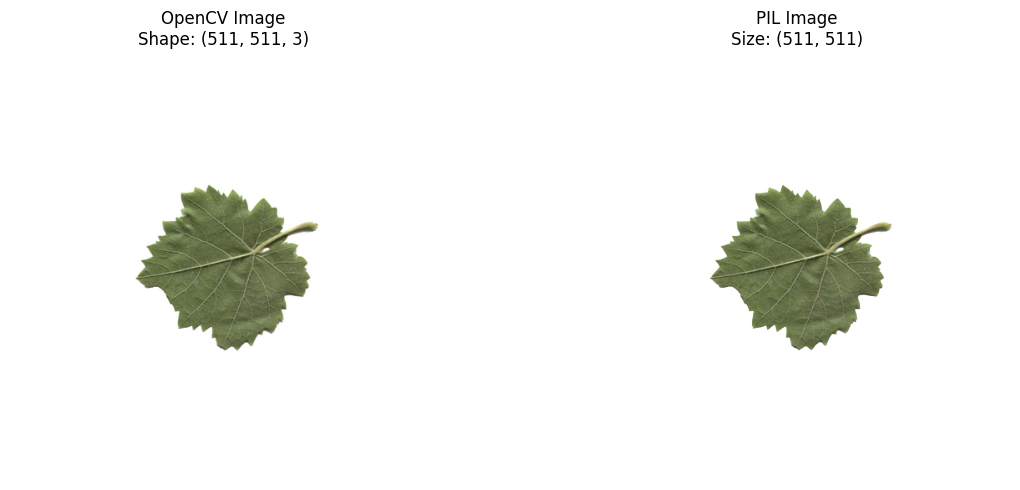

Image shape (OpenCV): (511, 511, 3)
Image size (PIL): (511, 511)
Data type: uint8
Value range: 18 - 255


In [6]:
# Load and display a sample image
dataset_path = Path('../Grapevine_Leaves_Image_Dataset')
sample_image_path = dataset_path / 'Ak' / 'Ak (1).png'

# Read image using OpenCV
img_cv = cv2.imread(str(sample_image_path))
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Read image using PIL
img_pil = Image.open(sample_image_path)

# Display both
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(img_rgb)
axes[0].set_title(f'OpenCV Image\nShape: {img_rgb.shape}')
axes[0].axis('off')

axes[1].imshow(img_pil)
axes[1].set_title(f'PIL Image\nSize: {img_pil.size}')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape (OpenCV): {img_rgb.shape}")
print(f"Image size (PIL): {img_pil.size}")
print(f"Data type: {img_rgb.dtype}")
print(f"Value range: {img_rgb.min()} - {img_rgb.max()}")

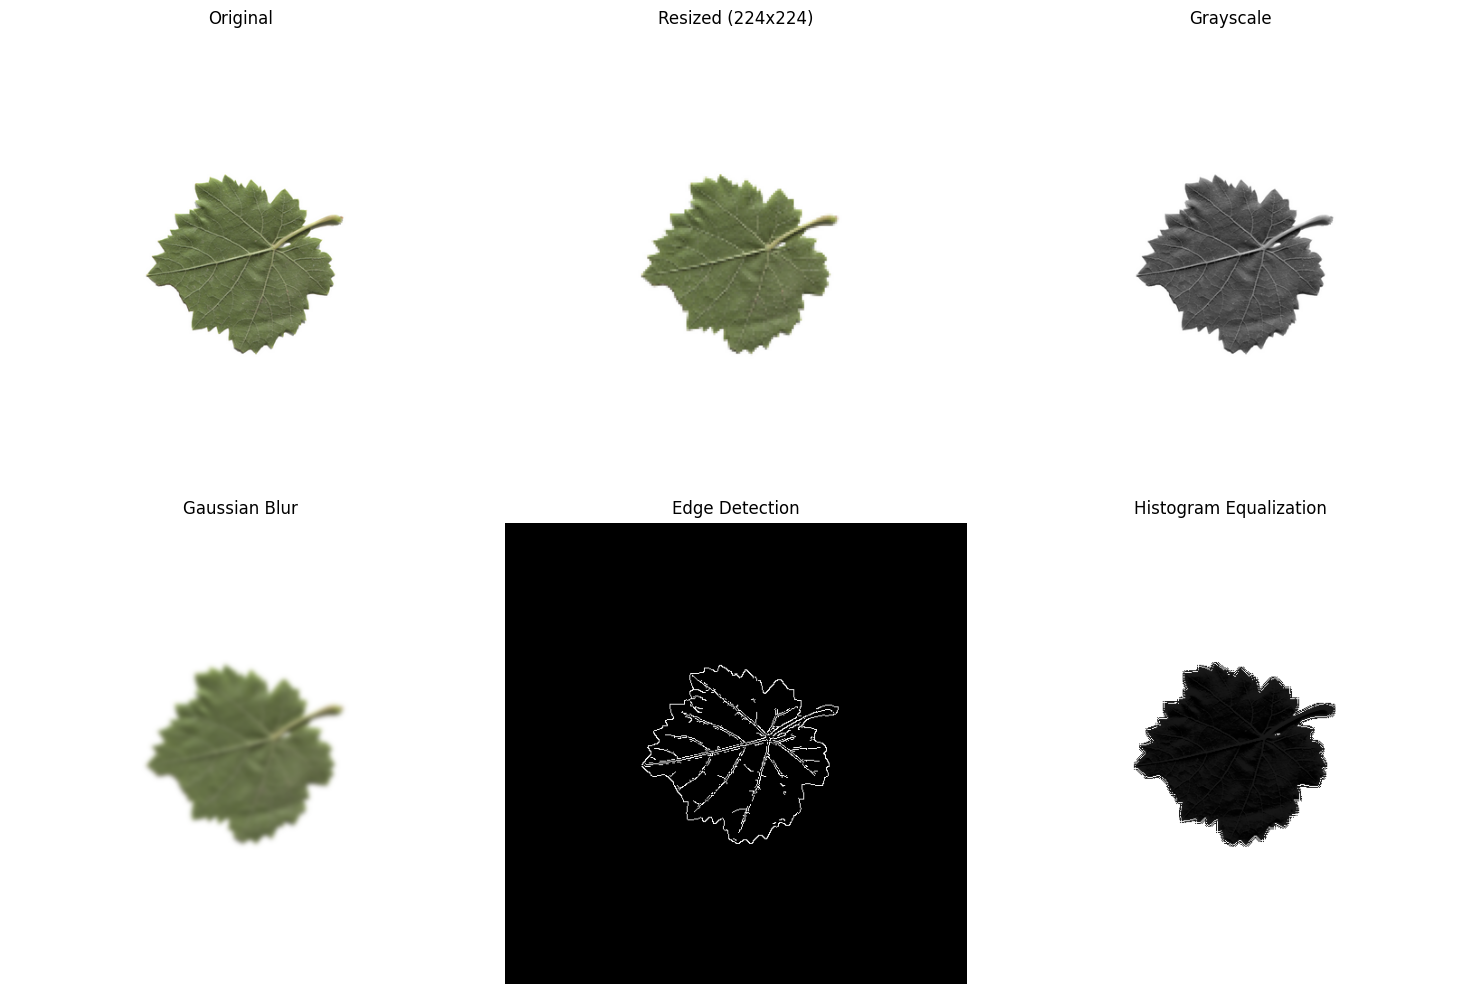

In [4]:
def demonstrate_image_preprocessing(image_path):
    """
    Demonstrate common image preprocessing techniques
    """
    # Load image
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 1. Resize
    img_resized = cv2.resize(img_rgb, (224, 224))
    
    # 2. Grayscale conversion
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    
    # 3. Gaussian blur
    img_blurred = cv2.GaussianBlur(img_rgb, (15, 15), 0)
    
    # 4. Edge detection
    edges = cv2.Canny(img_gray, 100, 200)
    
    # 5. Histogram equalization
    img_gray_eq = cv2.equalizeHist(img_gray)
    
    # Display results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img_resized)
    axes[0, 1].set_title('Resized (224x224)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(img_gray, cmap='gray')
    axes[0, 2].set_title('Grayscale')
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(img_blurred)
    axes[1, 0].set_title('Gaussian Blur')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(edges, cmap='gray')
    axes[1, 1].set_title('Edge Detection')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(img_gray_eq, cmap='gray')
    axes[1, 2].set_title('Histogram Equalization')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Demonstrate preprocessing
demonstrate_image_preprocessing(sample_image_path)

## 4. Dataset Exploration & Analysis

Systematic dataset exploration is crucial for understanding your data and designing appropriate preprocessing pipelines.

Dataset: Grapevine_Leaves_Image_Dataset
Number of classes: 5
Classes: ['Dimnit', 'Ak', 'Ala_Idris', 'Nazli', 'Buzgulu']

Dimnit: 100 images
Ak: 100 images
Ala_Idris: 100 images
Nazli: 100 images
Buzgulu: 100 images

Total images: 500


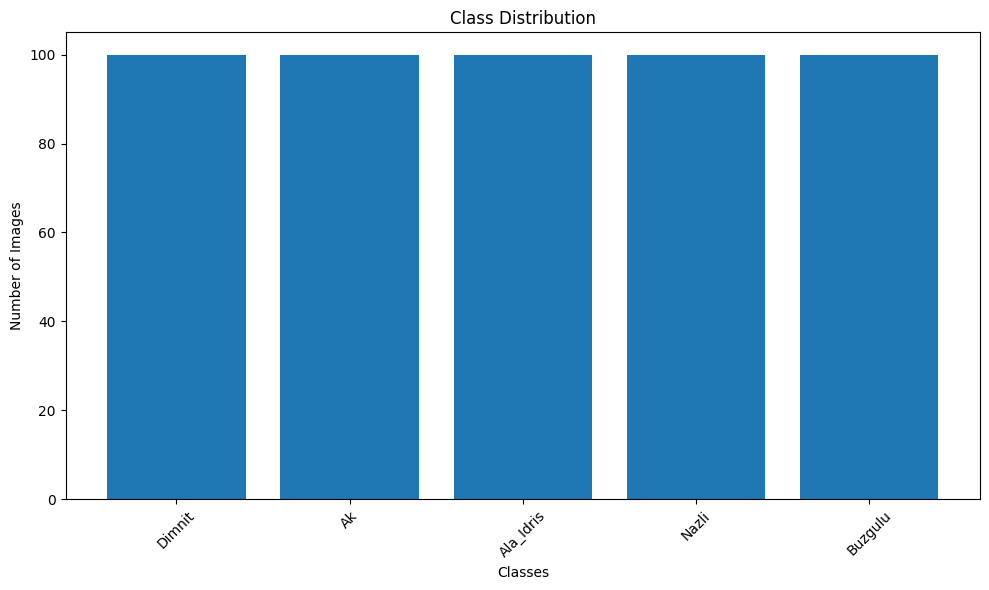

In [7]:
def explore_dataset_structure(dataset_path):
    """
    Explore the structure and statistics of the image dataset
    """
    dataset_path = Path(dataset_path)
    
    # Get class directories
    class_dirs = [d for d in dataset_path.iterdir() if d.is_dir()]
    class_names = [d.name for d in class_dirs]
    
    print(f"Dataset: {dataset_path.name}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Classes: {class_names}")
    print("\n" + "="*50)
    
    # Count images per class
    class_counts = {}
    total_images = 0
    
    for class_dir in class_dirs:
        image_files = list(class_dir.glob('*.png')) + list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.jpeg'))
        count = len(image_files)
        class_counts[class_dir.name] = count
        total_images += count
        print(f"{class_dir.name}: {count} images")
    
    print(f"\nTotal images: {total_images}")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return class_names, class_counts

# Explore our dataset
class_names, class_counts = explore_dataset_structure(dataset_path)

Image Statistics Summary:
       widths  heights  channels  file_sizes
count    50.0     50.0      50.0   50.000000
mean    511.0    511.0       3.0  225.002461
std       0.0      0.0       0.0   74.130832
min     511.0    511.0       3.0  101.956055
25%     511.0    511.0       3.0  179.958740
50%     511.0    511.0       3.0  205.871582
75%     511.0    511.0       3.0  287.685547
max     511.0    511.0       3.0  393.816406


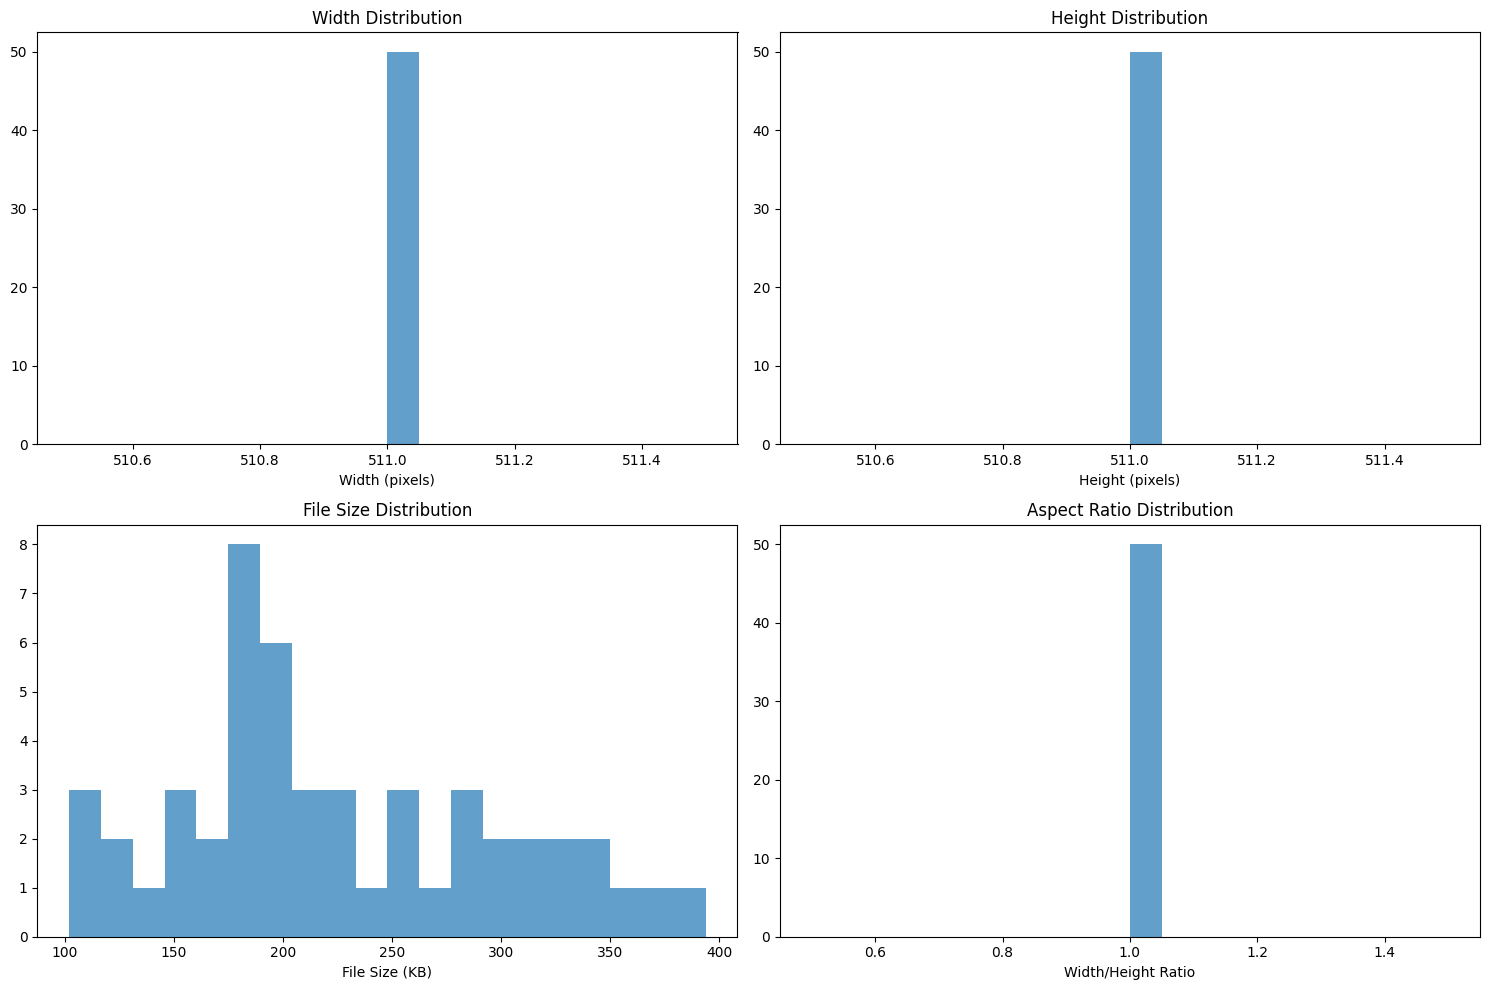

In [8]:
def analyze_image_properties(dataset_path, class_names, sample_size=10):
    """
    Analyze image properties like dimensions, channels, file sizes
    """
    dataset_path = Path(dataset_path)
    
    image_stats = {
        'widths': [],
        'heights': [],
        'channels': [],
        'file_sizes': [],
        'classes': []
    }
    
    # Sample images from each class
    for class_name in class_names:
        class_dir = dataset_path / class_name
        image_files = list(class_dir.glob('*.png'))[:sample_size]
        
        for img_path in image_files:
            # Load image
            img = cv2.imread(str(img_path))
            if img is not None:
                h, w, c = img.shape
                file_size = img_path.stat().st_size / 1024  # KB
                
                image_stats['heights'].append(h)
                image_stats['widths'].append(w)
                image_stats['channels'].append(c)
                image_stats['file_sizes'].append(file_size)
                image_stats['classes'].append(class_name)
    
    # Convert to DataFrame for analysis
    df_stats = pd.DataFrame(image_stats)
    
    print("Image Statistics Summary:")
    print(df_stats.describe())
    
    # Visualize distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Width distribution
    axes[0, 0].hist(df_stats['widths'], bins=20, alpha=0.7)
    axes[0, 0].set_title('Width Distribution')
    axes[0, 0].set_xlabel('Width (pixels)')
    
    # Height distribution
    axes[0, 1].hist(df_stats['heights'], bins=20, alpha=0.7)
    axes[0, 1].set_title('Height Distribution')
    axes[0, 1].set_xlabel('Height (pixels)')
    
    # File size distribution
    axes[1, 0].hist(df_stats['file_sizes'], bins=20, alpha=0.7)
    axes[1, 0].set_title('File Size Distribution')
    axes[1, 0].set_xlabel('File Size (KB)')
    
    # Aspect ratio
    aspect_ratios = df_stats['widths'] / df_stats['heights']
    axes[1, 1].hist(aspect_ratios, bins=20, alpha=0.7)
    axes[1, 1].set_title('Aspect Ratio Distribution')
    axes[1, 1].set_xlabel('Width/Height Ratio')
    
    plt.tight_layout()
    plt.show()
    
    return df_stats

# Analyze image properties
image_stats_df = analyze_image_properties(dataset_path, class_names)

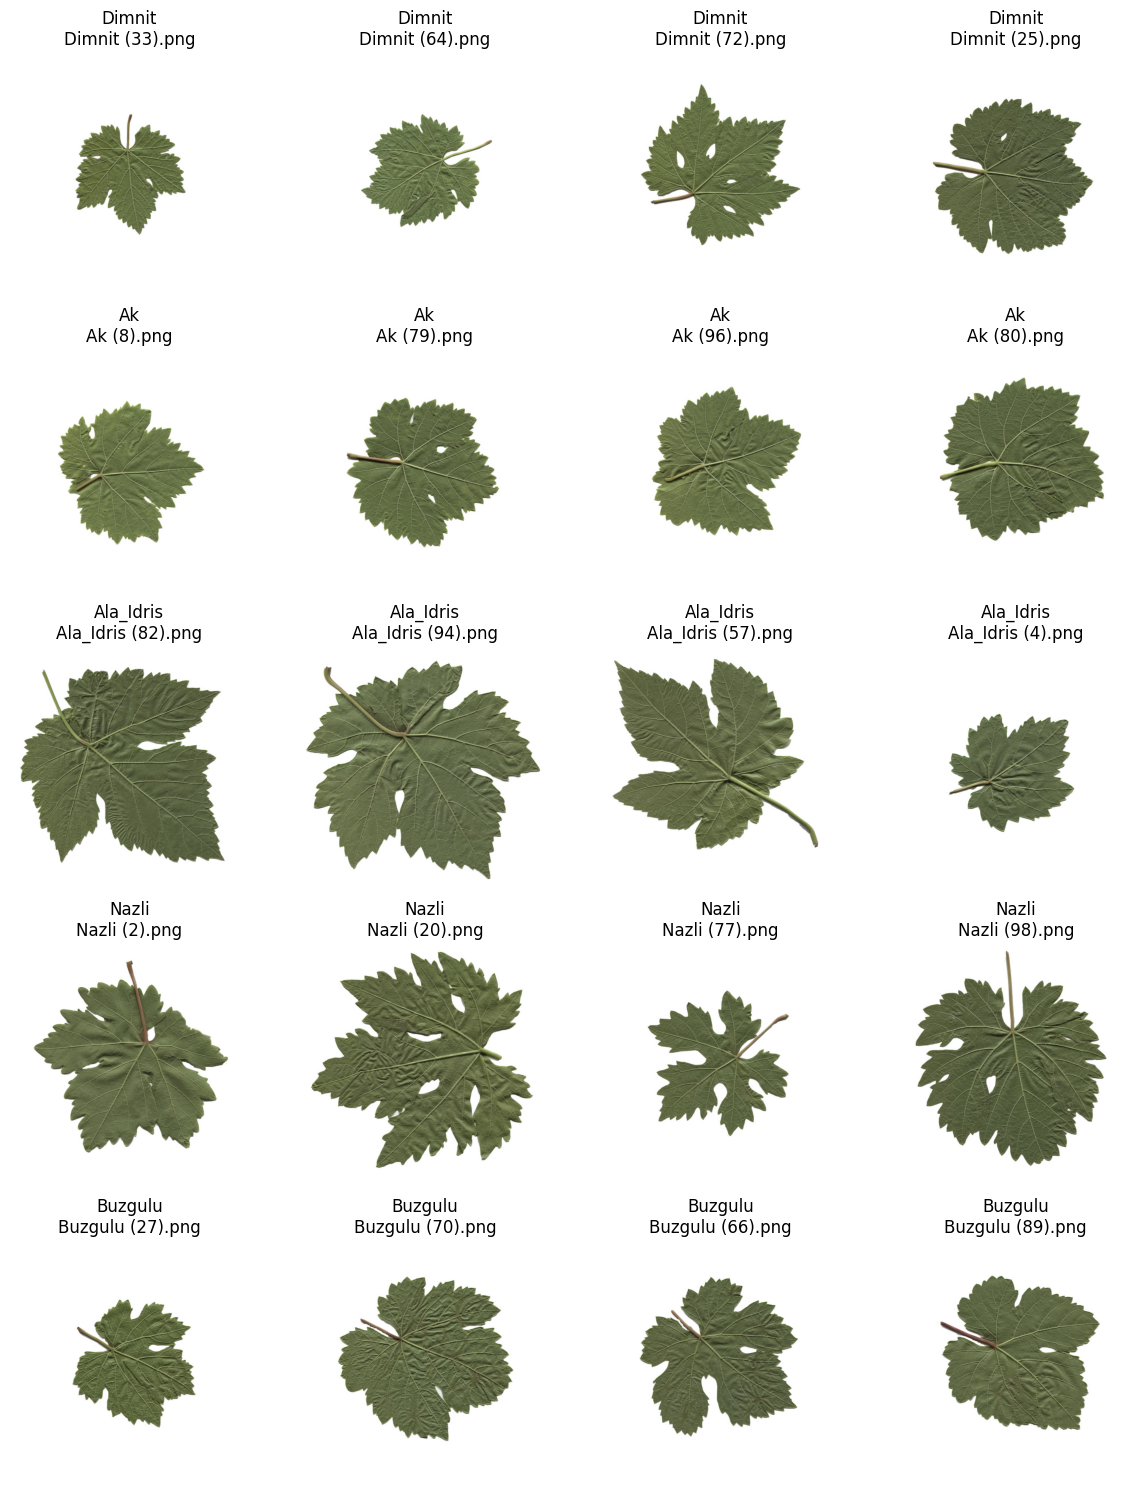

In [12]:
def visualize_sample_images(dataset_path, class_names, samples_per_class=4):
    """
    Visualize sample images from each class
    """
    dataset_path = Path(dataset_path)
    
    fig, axes = plt.subplots(len(class_names), samples_per_class, 
                            figsize=(samples_per_class * 3, len(class_names) * 3))
    
    for i, class_name in enumerate(class_names):
        class_dir = dataset_path / class_name
        image_files = list(class_dir.glob('*.png'))[:samples_per_class]
        
        for j, img_path in enumerate(image_files):
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if len(class_names) == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            
            ax.imshow(img_rgb)
            ax.set_title(f'{class_name}\n{img_path.name}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_sample_images(dataset_path, class_names)

## 5. Preprocessing Pipeline Design

Based on our dataset exploration, let's design an appropriate preprocessing pipeline.

In [13]:
def load_dataset(dataset_path, img_size=(224, 224), test_size=0.2, val_size=0.2):
    """
    Load and preprocess the entire dataset
    """
    dataset_path = Path(dataset_path)
    
    images = []
    labels = []
    
    # Load all images
    for class_dir in dataset_path.iterdir():
        if class_dir.is_dir() and class_dir.name != '.DS_Store':
            class_name = class_dir.name
            
            for img_path in class_dir.glob('*.png'):
                # Load and preprocess image
                img = cv2.imread(str(img_path))
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_resized = cv2.resize(img_rgb, img_size)
                    img_normalized = img_resized.astype(np.float32) / 255.0
                    
                    images.append(img_normalized)
                    labels.append(class_name)
    
    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded, test_size=test_size, stratify=y_encoded, random_state=42
    )
    # creating the evaluation set out of the training set
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), stratify=y_temp, random_state=42
    )
    
    print(f"Dataset loaded successfully!")
    print(f"Training set: {X_train.shape[0]} images")
    print(f"Validation set: {X_val.shape[0]} images")
    print(f"Test set: {X_test.shape[0]} images")
    print(f"Image shape: {X_train.shape[1:]}")
    print(f"Number of classes: {len(label_encoder.classes_)}")
    print(f"Classes: {label_encoder.classes_}")
    
    return (X_train, X_val, X_test, y_train, y_val, y_test), label_encoder

# Load the dataset
(X_train, X_val, X_test, y_train, y_val, y_test), label_encoder = load_dataset(dataset_path)

Dataset loaded successfully!
Training set: 300 images
Validation set: 100 images
Test set: 100 images
Image shape: (224, 224, 3)
Number of classes: 5
Classes: ['Ak' 'Ala_Idris' 'Buzgulu' 'Dimnit' 'Nazli']


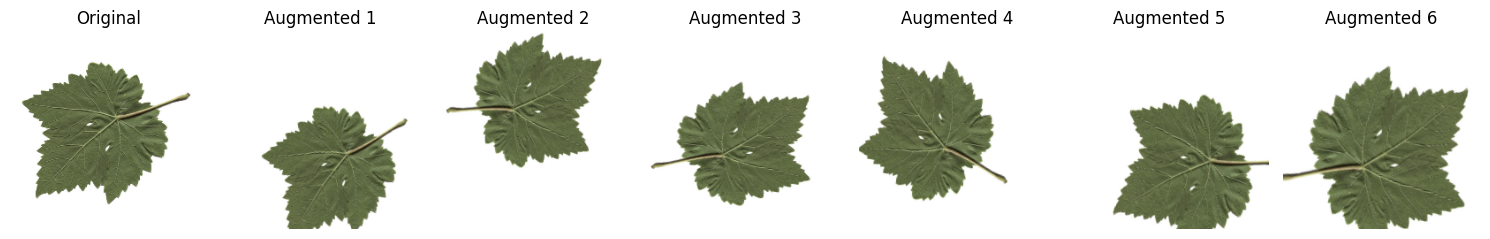

In [16]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# No augmentation for validation/test
val_datagen = ImageDataGenerator()

# Demonstrate data augmentation
def show_augmentation_examples(image, datagen, num_examples=6):
    """
    Show examples of data augmentation
    """
    # Reshape for generator
    image_batch = image.reshape((1,) + image.shape)
    
    fig, axes = plt.subplots(1, num_examples + 1, figsize=(15, 3))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Augmented images
    i = 1
    for batch in datagen.flow(image_batch, batch_size=1):
        axes[i].imshow(batch[0])
        axes[i].set_title(f'Augmented {i}')
        axes[i].axis('off')
        i += 1
        if i > num_examples:
            break
    
    plt.tight_layout()
    plt.show()

# Show augmentation examples
sample_image = X_train[0]
show_augmentation_examples(sample_image, train_datagen)

## 6. Building Your First CNN

Let's build a Convolutional Neural Network for our grapevine leaf classification task.

In [ ]:
def create_simple_cnn(input_shape, num_classes):
    """
    Create a simple CNN architecture
    """
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)

model = create_simple_cnn(input_shape, num_classes)
model.summary()

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
]

print("Model compiled successfully!")

In [ ]:
# Train the model
EPOCHS = 50
BATCH_SIZE = 32

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

In [ ]:
def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

## 7. Model Evaluation

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
def show_prediction_examples(model, X_test, y_test, label_encoder, num_examples=8):
    """
    Show prediction examples with confidence scores
    """
    # Get random samples
    indices = np.random.choice(len(X_test), num_examples, replace=False)
    
    # Make predictions
    predictions = model.predict(X_test[indices])
    predicted_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    
    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        # Display image
        axes[i].imshow(X_test[idx])
        
        # Get labels
        true_label = label_encoder.classes_[y_test[idx]]
        pred_label = label_encoder.classes_[predicted_classes[i]]
        confidence = confidence_scores[i]
        
        # Set title with color coding
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                         color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show prediction examples
show_prediction_examples(model, X_test, y_test, label_encoder)

## 8. Transfer Learning (Bonus)

Let's also try transfer learning with a pre-trained MobileNetV2 model.

In [ ]:
def create_transfer_learning_model(input_shape, num_classes):
    """
    Create a transfer learning model using MobileNetV2
    """
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Add custom classifier
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create transfer learning model
transfer_model = create_transfer_learning_model(input_shape, num_classes)
transfer_model.summary()

In [ ]:
# Compile transfer learning model
transfer_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train transfer learning model
transfer_history = transfer_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=20,  # Fewer epochs for transfer learning
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# Plot transfer learning history
plot_training_history(transfer_history)

In [ ]:
# Compare both models
print("Model Comparison:")
print("="*50)

# Simple CNN
cnn_test_loss, cnn_test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Simple CNN - Test Accuracy: {cnn_test_accuracy:.4f}")

# Transfer Learning
transfer_test_loss, transfer_test_accuracy = transfer_model.evaluate(X_test, y_test, verbose=0)
print(f"Transfer Learning - Test Accuracy: {transfer_test_accuracy:.4f}")

print(f"\nImprovement: {transfer_test_accuracy - cnn_test_accuracy:.4f}")

## 9. Next Steps & Deliverables

### This Week's Deliverable: Image preprocessing + dataset setup

**What you've accomplished:**
1. ✅ Learned neural network fundamentals
2. ✅ Mastered OpenCV basics for image preprocessing
3. ✅ Conducted systematic dataset exploration
4. ✅ Designed preprocessing pipelines
5. ✅ Built and trained your first CNN
6. ✅ Implemented transfer learning

### For Saturday's Presentation: "Dataset Insights + Preprocessing Plan"

**Prepare to present:**
1. Dataset characteristics and class distribution
2. Image properties analysis (dimensions, file sizes, etc.)
3. Preprocessing pipeline design decisions
4. Data augmentation strategy
5. Initial model results and insights

### Self-study: TensorFlow basics, image augmentation practice

**Recommended activities:**
1. Experiment with different augmentation parameters
2. Try different CNN architectures
3. Explore other pre-trained models
4. Practice with TensorFlow/Keras documentation

### Week 5 Preview: Advanced CNN Architectures
- ResNet, DenseNet, EfficientNet
- Advanced training techniques
- Model optimization and deployment

## 10. Practice Exercises

### Exercise 1: Modify the CNN Architecture
Try adding more convolutional layers or changing filter sizes. How does it affect performance?

### Exercise 2: Experiment with Data Augmentation
Modify the augmentation parameters. What happens if you increase/decrease rotation_range?

### Exercise 3: Feature Visualization
Try to visualize what the convolutional layers are learning using activation maps.

### Exercise 4: Different Optimizers
Compare Adam, SGD, and RMSprop optimizers. Which works best for this dataset?

### Exercise 5: Class Imbalance
What would you do if one class had significantly fewer images? Research and implement solutions.